# Kaggle Project - Home Price Advanced Regression Techniques
# Part 3 - Preprocessing and Feature Engineering

Following the EDA performed in Part 2, this section preprocesses data and engineers features for both train and test set.

## Table of Content
1. [Load Libraries](#Step-1-Load-Libraries)
2. [Load Data](#Step-2-Load-Data)
3. [Data Preprocessing](#Step-3-Data-Preprocessing)
4. [Feature Engineering](#Step-4-Feature-Engineering)
5. [Save Data](#Step-5-Save-Data)

## Summary
1. **Numerical Feature/Label Transformation**
The [histogram](#Step-4-Numerical-Feature-Transformation) shows that the data for the following features/label are not normally distributed. PowerTransformer (i.e., transform with Johnson SU;  distribution) can help transform the distribution to normal.

             ['LotFrontage', 
              'LotArea', 
              'BsmtUnfSF', 
              'TotalBsmtSF', 
              '1stFlrSF',  
              'GrLivArea',
              'GarageArea']
              ['SalePrice]
          
2. **Categorical Feature Encoding** 

The [Analysis of Variance (ANOVA)](#5.2---1-Way-ANOVA) test shows the partition of variance of the most categorical features are statistically significant. Therefore, this project propose to encoded these features based on the mean of the `SalePrice`. The `'LandSlope', 'Street', 'Utilities'` are removed due to either:
**a.** partition of variance are not statistically significant, or
**b.** highly unbalanced level (no enough information to learn from).

3. **Feature Engineering with Polynomial Terms**

Based on the [pairplot](#6.3---Pairplot), the regression model may benefit from by adding the 3rd degree polynomial terms for the following features, though at the risk of model overfitting.

            ['BldgType',
             'ExterCond',
             'Exterior2nd',
             'BsmtExposure',
             'BsmtFinType1',
             'BsmtFinType2',
             'Fence'
             'Functional',
             'PoolQC',
             'SaleCondition',
             'Heating',
             'GarageQual',
             'GarageCond',
             'MiscFeature']

## Step-1 Load Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

%matplotlib inline

## Step-2 Load Data

In [24]:
%store -r train
%store -r test
%store -r num_feats
%store -r power_feats
%store -r cat_feats
%store -r poly_feats

In [25]:
X_train = train.drop(columns='SalePrice').copy()
y = train[['SalePrice']].copy()
X_test = test.copy()

In [26]:
print(X_train.shape)
print(X_test.shape)

(1458, 79)
(1459, 79)


## Step-3 Data Preprocessing

### 3.1 - Drop `Street`, `Utilities`, and  `LandSlope`

In [27]:
feat_drop = ['Street', 'Utilities', 'LandSlope']
X_train.drop(columns=feat_drop, inplace=True)
X_test.drop(columns=feat_drop, inplace=True)

In [28]:
# Check the shape to confirm the feature removal
print(X_train.shape)
print(X_test.shape)

(1458, 76)
(1459, 76)


### 3.0 - Fill Missing Values

- Fill `0` for numerical features
- Fill `NA` for categorical features

In [29]:
def fill_na(df, num_feats, cat_feats):
    for nf in num_feats:
        df.loc[:, nf] = df[nf].fillna(0)  # inplace doesn't work when use fillna(0) with df.loc   
    for cf in cat_feats:
        if df[cf].isnull().any():  
            df.loc[:, cf] = df.loc[:, cf].astype('category')
            df.loc[:, cf].cat.add_categories(['NA'], inplace=True) # add new category 'NA'
            df.loc[:, cf].fillna('NA', inplace=True) # fill `NaN` with 'NA'
    return df

X_train = fill_na(X_train, num_feats, cat_feats)
X_test = fill_na(X_test, num_feats, cat_feats)
print(f'There is {X_train.isna().sum().sum()} missing values in X_train') # confirm all NaN are replaced
print(f'There is {X_test.isna().sum().sum()} missing values in X_test') # confirm all NaN are replaced

There is 0 missing values in X_train
There is 0 missing values in X_test


### 3.1 - `SalePrice` Transformation

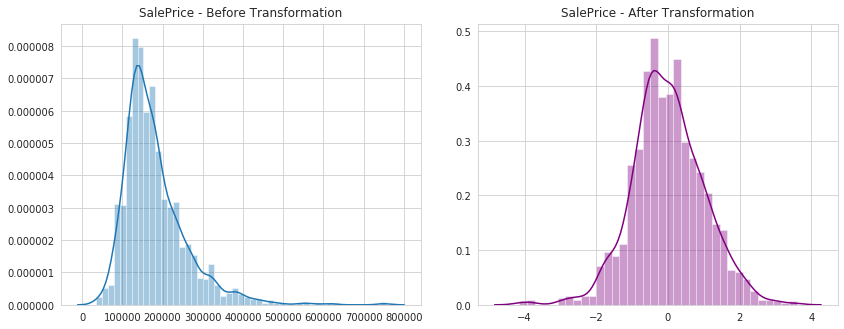

In [30]:
pt = PowerTransformer(method='yeo-johnson', # use yeo-johnson transformation
                      standardize=True, 
                      copy=True)
y_pt = pt.fit_transform(y)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.tight_layout(pad=3)
    sns.distplot(y, ax=axes[0])
    axes[0].set_title('SalePrice - Before Transformation', pad=8)
    sns.distplot(y_pt, color='purple', ax=axes[1])
    axes[1].set_title('SalePrice - After Transformation', pad=8);

### 3.2 - Numerical Feature Transformation

In [31]:
# Function to perform the power transform
def power_transform(df_train, df_test, num_feats):
    df_train_update = df_train.copy()
    df_test_update = df_test.copy()
    for f in num_feats:
        pt = PowerTransformer(method='yeo-johnson', # use yeo-johnson transformation
                              standardize=True, 
                              copy=True)
        df_train_update.loc[:, f] = pt.fit_transform(df_train_update[[f]]).ravel()
        df_test_update.loc[:, f] = pt.transform(df_test_update[[f]]).ravel()
    return df_train_update, df_test_update

# Run the function to excute the transformation
X_train_update, X_test_update = power_transform(X_train, X_test, power_feats)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


/Users/kaizhao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


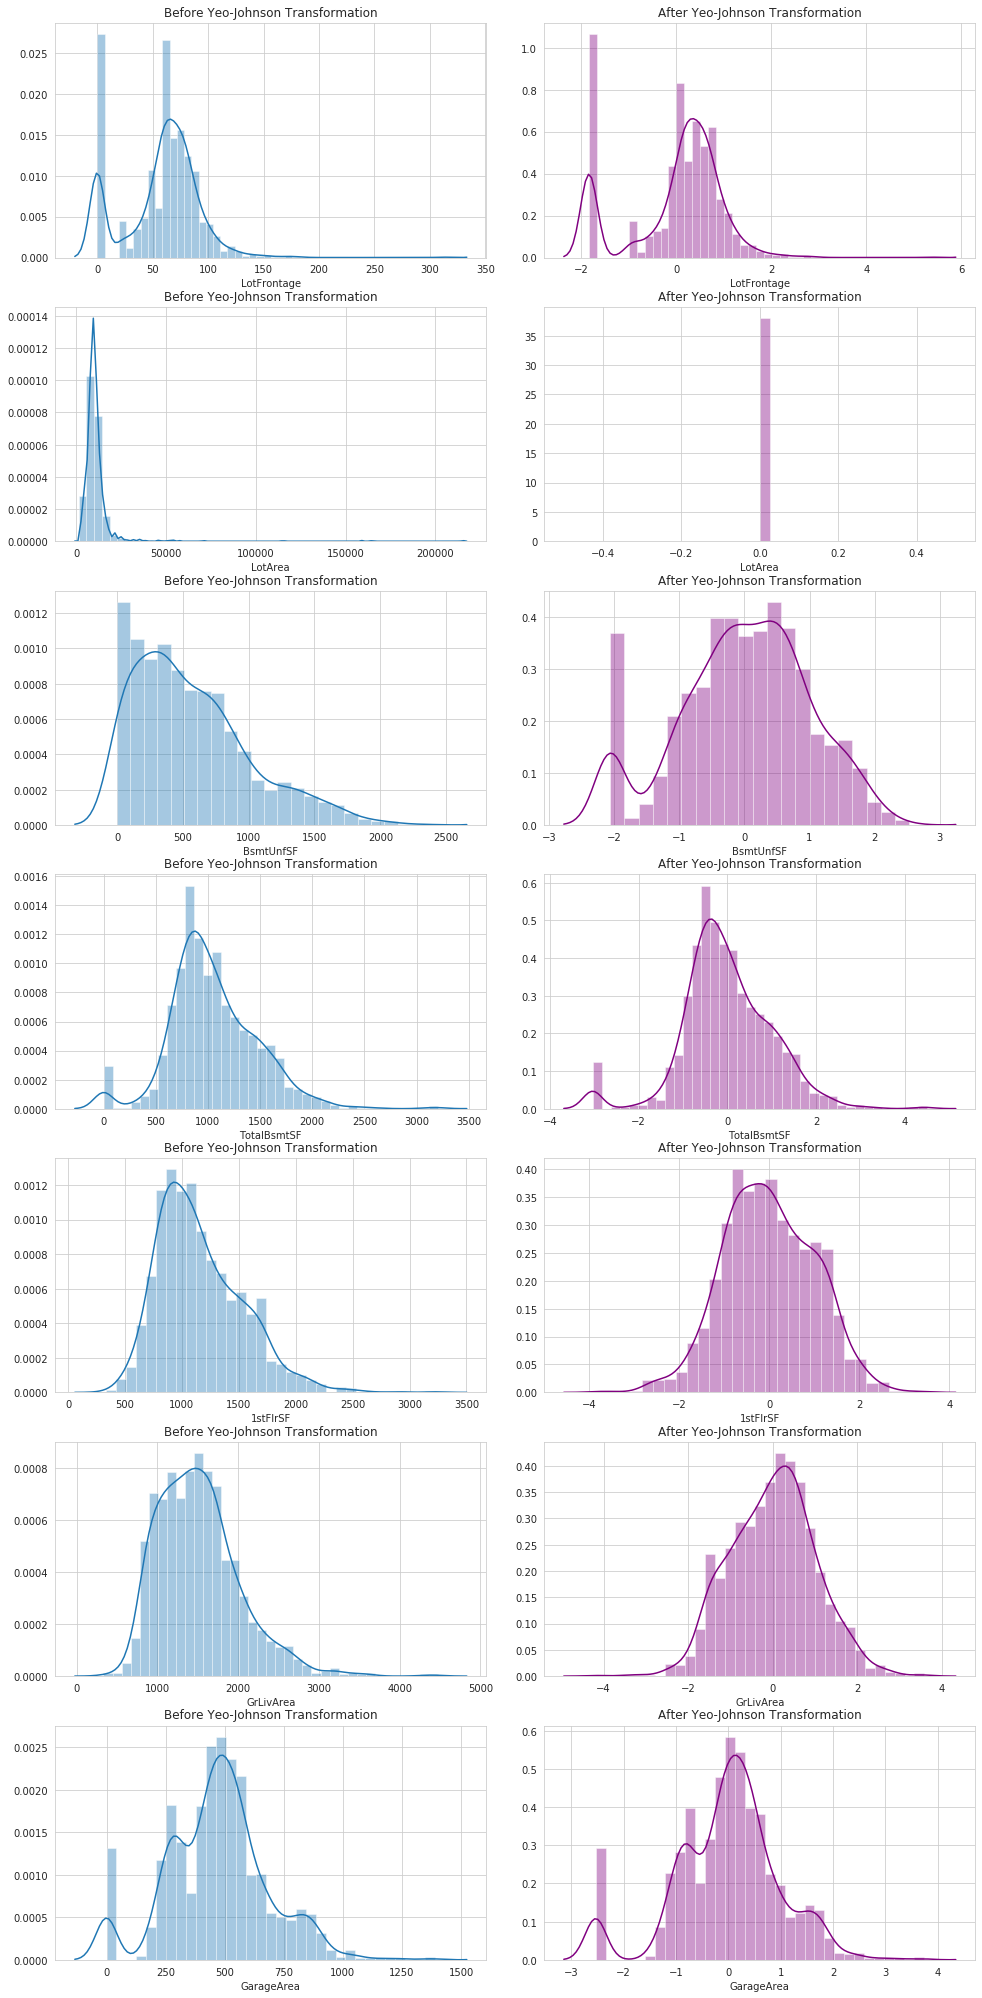

In [32]:
# Function to plot to confirm the transformation
def plot_pair(df1, df2, features, ncols, title1, title2):
    nrows = int(np.ceil(len(features)*2/ncols))
    with sns.axes_style("whitegrid"):
        fit, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 4*nrows))
        plt.tight_layout(pad=3)
        for i in range(nrows):
            for j in range(ncols):
                if j % 2 == 0:
                    sns.distplot(df1[features[i]], ax=axes[i, j])
                    axes[i, j].set_title(title1, pad=7)
                else:
                    sns.distplot(df2[features[i]], color='purple', ax=axes[i, j])
                    axes[i, j].set_title(title2, pad=7)

# Execute the function to confirm the transformation though plots
plot_pair(df1=X_train, 
          df2=X_train_update, 
          features=power_feats, 
          ncols=2,
          title1='Before Yeo-Johnson Transformation',
          title2='After Yeo-Johnson Transformation')

### 3.3 - Categorical Feature Encoding

In [33]:
# Temporarily add label
X_train_update.insert(X_train_update.shape[1], 'SalePrice', train['SalePrice'])

In [34]:
# Function for categorical feature encoding
def cat_encode(df_train, df_test, features, label, method='mean'):
    for f in features:
        print(f)
        rank = df_train.groupby(f)[label].agg(method).rank().to_dict()   # create the rank based on mean
        df_train[f] = df_train[f].apply(lambda x: rank[x]).astype('int') # encode and convert category to integer
        df_test[f] = df_test[f].apply(lambda x: rank[x]).astype('int')   # encode and convert category to integer
# Run function to execute the encoding
cat_encode(X_train_update, X_test_update, cat_feats, 'SalePrice')
# Remove label
X_train_update.drop(columns='SalePrice', inplace=True)

MiscFeature
SaleType
Alley
Exterior2nd
Fence
Functional
BsmtFinType2
BsmtExposure
FireplaceQu
RoofStyle
Condition2
LotShape
ExterQual
BsmtQual
PavedDrive
BsmtFinType1
Electrical
PoolQC
MasVnrType
Foundation
RoofMatl
ExterCond
Exterior1st
GarageQual
Neighborhood
MSZoning
BsmtCond
Condition1
GarageType
CentralAir
SaleCondition
HeatingQC
KitchenQual
LandContour
LotConfig
GarageFinish
HouseStyle
Heating
BldgType
GarageCond


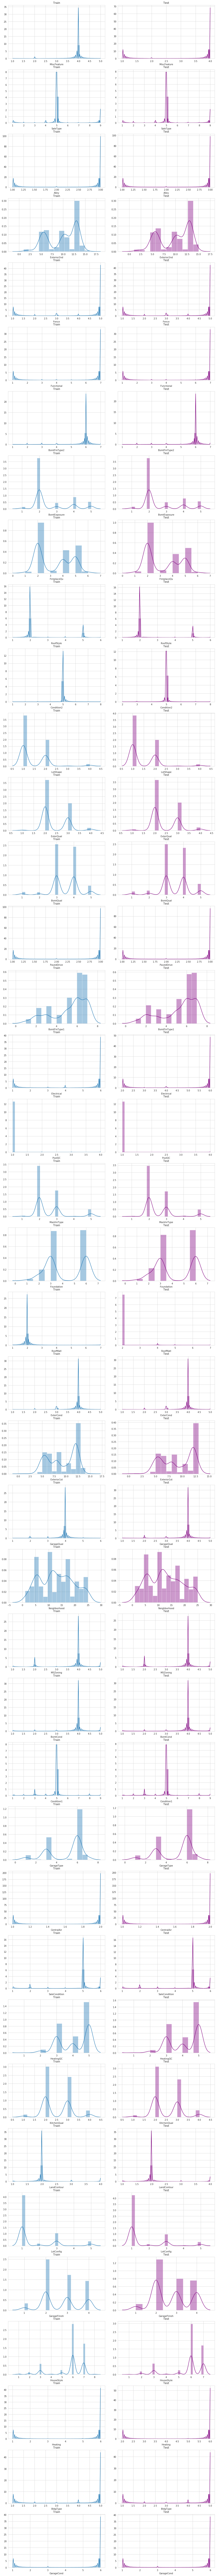

In [35]:
# Plot to confirm the encoding
plot_pair(df1=X_train_update, 
          df2=X_test_update, 
          features=cat_feats, 
          ncols=2,
          title1='Train',
          title2='Test')

## Step-4 Feature Engineering

### 4.1 - Define Function

In [36]:
# Define function for adding polynomial terms
def add_poly_term(df, features, order):
    for f in features:
        df[f + f'_{order}'] = df[f].apply(lambda x: x**order)

### 4.2 - Add Polynomial Terms

In [37]:
# Number of features for to add polynomial
print(f'Polynomial terms will be added to {len(poly_feats)} features.')
# Check number of features before add the polynomial terms
print(f'There are {X_train_update.shape[1]} features in X_train before adding the poly terms.')
print(f'There are {X_test_update.shape[1]} features in X_test before adding the poly terms.')

# Add quadratic terms
add_poly_term(X_train_update, poly_feats, 2)
add_poly_term(X_test_update, poly_feats, 2)
# Add cubic terms
add_poly_term(X_train_update, poly_feats, 3)
add_poly_term(X_test_update, poly_feats, 3)

# Check number of features after add the polynomial terms
print(f'There are {X_train_update.shape[1]} features in X_train after adding the poly terms.')
print(f'There are {X_test_update.shape[1]} features in X_test after adding the poly terms.')

Polynomial terms will be added to 14 features.
There are 76 features in X_train before adding the poly terms.
There are 76 features in X_test before adding the poly terms.
There are 104 features in X_train after adding the poly terms.
There are 104 features in X_test after adding the poly terms.


## Step-5 Save Data

In [38]:
%store X_train_update
%store X_test_update
%store y
%store y_pt

Stored 'X_train_update' (DataFrame)
Stored 'X_test_update' (DataFrame)
Stored 'y' (DataFrame)
Stored 'y_pt' (ndarray)
